In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

zsh:1: command not found: pip


In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [2]:
tf.keras.backend.set_floatx("float64")

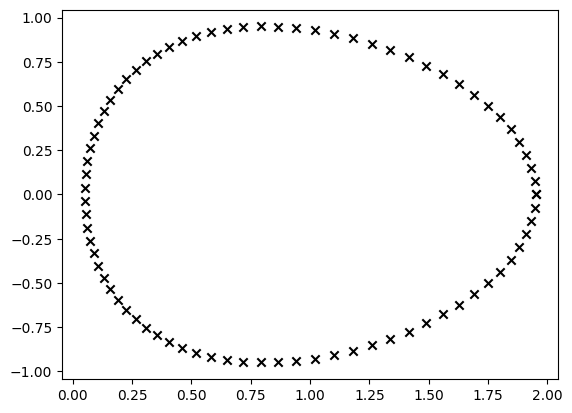

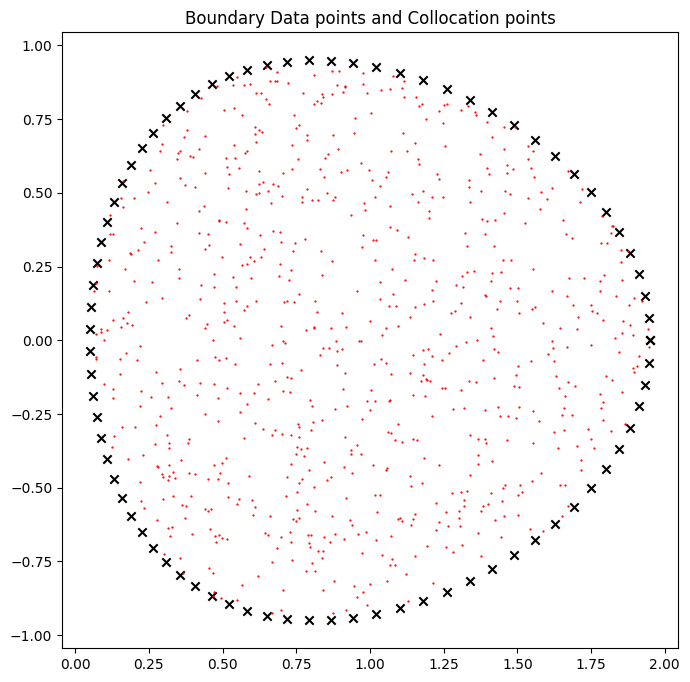

In [5]:
# We solve Grad-Shafranov (Soloviev case) dor Spheromak equilibrium.
# See below the shape parameters ....... see paper
#..............................................................

### data generation on boundary ..............
epsi=0.95
alfa=np.arcsin(0.2)
kapa=1.

n_bc = 1
n_data_per_bc = 80

theta = np.linspace(0, 2*np.pi,n_data_per_bc)
#theta=2.*np.pi*np.random.rand(n_data_per_bc )

x= 1 +epsi*np.cos(theta + alfa*np.sin(theta))
y = kapa*epsi*np.sin(theta)

data = np.zeros([n_bc, n_data_per_bc, 3])
data[0, :, 0] = x 
data[0, :, 1] = y
data[0, :, 2] = 0.000 

data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.show()

# collocation points ............................
Nc = 800
colloc = np.zeros([Nc, 2]) 

engine = qmc.LatinHypercube(d=2)
points = engine.random(n=Nc)

points[:, 0] = points[:, 0]*2*np.pi

colloc[:, 1] = kapa*epsi*points[:, 1]**0.5*np.sin(points[:, 0])
colloc[:, 0] = 1 + epsi*points[:, 1]**0.5* np.cos(points[:, 0] + alfa*np.sin(points[:, 0]) )

#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])


#
plt.figure("", figsize=(8, 8))
plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=1.5, marker=".", c="r", label="CP")
plt.axis("square")
plt.show()

#

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [6]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, 
                neuron_per_layer=30, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [7]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 5, 30, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 30)                90        
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 1)                 31    

In [8]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u


In [9]:
# Residual equation with the coefficient AA to be chosen ...
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]

    AA=1
    F = x*u_xx + x*u_yy - u_x 
    F = F + x*((1-AA)*x*x + AA)
    
    retour = tf.reduce_mean(tf.square(F)) 

    return retour



In [10]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 1.439037426
  200, 0.122517550
  400, 0.018446613
  600, 0.003699182
  800, 0.001952546
 1000, 0.001103115
 1200, 0.000654470
 1400, 0.000477003
 1600, 0.000383084
 1800, 0.000309628
 2000, 0.000248947
 2200, 0.000201114
 2400, 0.000165598
 2600, 0.000140300
 2800, 0.000122314
 3000, 0.000108972
 3200, 0.000098377
 3400, 0.000089393
 3600, 0.000081422
 3800, 0.000074174
 4000, 0.000067921
 4200, 0.000062219
 4400, 0.000057141
 4600, 0.000111144
 4800, 0.000048172
 5000, 0.000044245
 5200, 0.000040519
 5400, 0.000037115
 5600, 0.000033864
 5800, 0.000030895
 6000, 0.000140090
 6200, 0.000025359
 6400, 0.000031127
 6600, 0.000020416
 6800, 0.000018731
 7000, 0.000016040
 7200, 0.000014112
 7400, 0.000012293
 7600, 0.000010703
 7800, 0.000009273
 8000, 0.000008077
 8200, 0.000007037
 8400, 0.000006263
 8600, 0.000005545
 8800, 0.000005803
 9000, 0.000004614
 9200, 0.000008767
 9400, 0.000004025
 9600, 0.000041209
 9800, 0.000003625
10000, 0.000052450
10200, 0.000026093
10400, 0.000

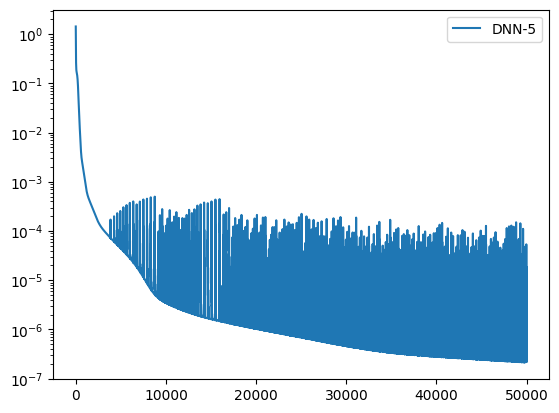

In [11]:
loss = 0
epochs = 50000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4)
epoch = 0
loss_values = np.array([])
L_values = np.array([])
l_values = np.array([])

#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = L + l
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    L_values = np.append(L_values, L)
    l_values = np.append(l_values, l)
    
    
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.9f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [12]:
n = 200
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])


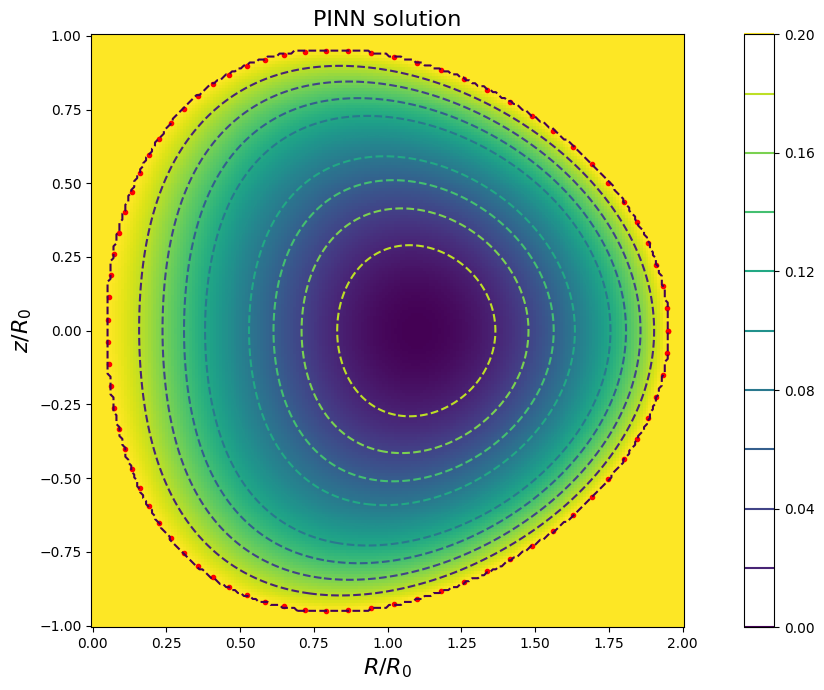

In [13]:
### plotting the results .....
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))
#
X = np.linspace(0., +2., n)
Y = np.linspace(-1., +1., n)
X0, Y0 = np.meshgrid(X, Y)


X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# predicted solution .....
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#

S2=S
S2[S2 < 0] =  0.00000000000000000
plt.pcolormesh(X0, Y0, S2, cmap="viridis_r")
plt.contour(X0, Y0, S2,10,linestyles='dashed',linewidths=1.5)
plt.colorbar(pad=-0.25)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r", label="BDP")
plt.xlabel("$R/R_0$",fontsize=16)
plt.ylabel("$z/R_0$",fontsize=16)
plt.xlim(0.66, 1.34)
plt.ylim(-0.52, 0.52)
plt.title("PINN solution",fontsize=16)
plt.tight_layout()
plt.axis("square")

plt.show()
#




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


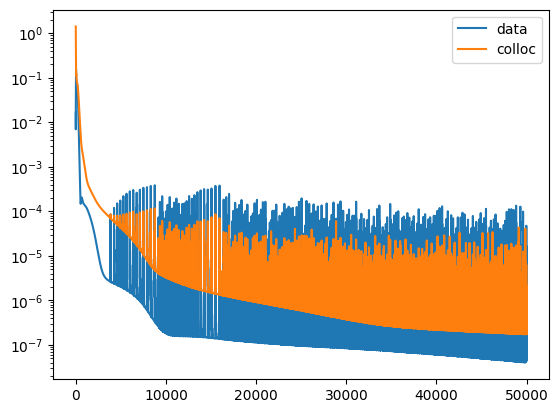

In [14]:
plt.legend()
plt.semilogy(l_values, label='data')
plt.legend()

plt.semilogy(L_values, label='colloc')
plt.legend()